In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

import lightning as pl
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint
import wandb

from model.vit_counter import LightningViTCounter
from data_handler import cellDataset

from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import h5py
import cv2
import numpy as np

In [2]:
train_images_list = glob("../Datasets/Cell Datasets/v3_dapi/resized/trainval/images/*.png")
val_images_list = glob("../Datasets/Cell Datasets/v3_dapi/resized/test/images/*.png")
test_images_list = glob("../Datasets/Cell Datasets/v3_dapi/resized/test/images/*.png")

print(f"Train images: {len(train_images_list)}")
print(f"Val images: {len(val_images_list)}")
print(f"Test images: {len(test_images_list)}")

config = {
    "batch_size": 8,
    "conv_layers": 3,
    "drop_rate": 0,
    "freeze": False,
    "lr": 1e-4,
    "vit_structure": "SAM-B",
    "model_path": "weights/sam_vit_b.pth"
}


Train images: 1098
Val images: 275
Test images: 275


In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = LightningViTCounter.load_from_checkpoint('ckpts/epoch=362-val_mae=27.52.ckpt',
                                                 train_images_list=train_images_list,
                                                 val_images_list=val_images_list,
                                                 test_images_list=test_images_list,
                                                 config=config)

model.prepare_data()
model.eval()
model.to(device)

# from lightning.pytorch.callbacks import ModelSummary   
# from lightning.pytorch import Trainer

# trainer = Trainer(
#     callbacks=[ModelSummary(max_depth=1)],
#     fast_dev_run=True
# )
# trainer.fit(model)

/Users/abdu/miniconda3/envs/light/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.2, which is newer than your current Lightning version: v2.1.0


LightningViTCounter(
  (encoder): CellCoder(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
  

In [4]:
transfroms = T.Compose([
    T.ToTensor(),
    # T.Resize((1024, 1024)),
    # T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [51]:
# generate density maps
dmaps = []
imgs = []
labels = []
for batch in model.test_dataloader():
    # get the images and labels
    print(batch[0].shape)
    image = batch[0].to(device)
    label = batch[1].to(device)

    # forward pass
    with torch.no_grad():
        output = model(image)

    dmaps.append(output.squeeze().detach().cpu())
    imgs.append(image.squeeze().detach().cpu())
    labels.append(label.squeeze().detach().cpu())

    if len(dmaps) > 20:
        break



torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])


In [ ]:
categories = {
    'best': ['294', '1299', '455'],
    'low': ['3020'],
    'mid': ['2785'],
    'high': ['2396'],
}

sam_dmaps = {}

# Flatten all unique image IDs to use in columns
all_ids = sorted(set(sum(categories.values(), [])))  # Remove duplicates

def predict_and_plot(model, img_tensor, original_img):
    with torch.no_grad():
        output = model(img_tensor)
    output = output.cpu().detach().numpy()
    pred_count = int(np.round(output.squeeze().squeeze().sum()))
    dmap = output[0][0]
    
    return dmap, pred_count

# make predictions and save the density maps
for category, image_ids in categories.items():
    for image_id in image_ids:
        # Load the original image
        original_img = cv2.imread(f"../Datasets/Cell Datasets/v3_dapi/resized/test/images/{image_id}.png")
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

        # Make predictions
        img_tensor = transfroms(original_img).unsqueeze(0).to(device)
        pred_dmap, pred_count = predict_and_plot(model, img_tensor, original_img)
        sam_dmaps[image_id] = pred_dmap


        print(f"Image ID: {image_id}, Predicted Count: {pred_count}")

# save sam_dmaps to numpy file
np.savez_compressed("sam_dmaps.npz", **sam_dmaps)

Image ID: 294, Predicted Count: 211
Image ID: 1299, Predicted Count: 36
Image ID: 455, Predicted Count: 72
Image ID: 3020, Predicted Count: 213
Image ID: 2785, Predicted Count: 411
Image ID: 2396, Predicted Count: 1691


In [ ]:
transfroms = T.Compose([
    T.ToTensor(),
    # T.Resize((1024, 1024)),
    # T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

sam_dmaps = {}

# Image fnames
all_ids = ['294', '1299', '455', '3020', '2785', '2396']  

def predict_and_plot(model, img_tensor, original_img):
    with torch.no_grad():
        output = model(img_tensor)
    output = output.cpu().detach().numpy()
    pred_count = int(np.round(output.squeeze().squeeze().sum()))
    dmap = output[0][0]
    
    return dmap, pred_count

# make predictions and save the density maps
for img_id in all_ids:
    # Load the original image
    original_img = cv2.imread(f"../Datasets/Cell Datasets/v3_dapi/resized/test/images/{image_id}.png")
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    # Make predictions
    img_tensor = transfroms(original_img).unsqueeze(0).to(device)
    pred_dmap, pred_count = predict_and_plot(model, img_tensor, original_img)
    sam_dmaps[image_id] = pred_dmap
    print(f"Image ID: {image_id}, Predicted Count: {pred_count}")

# save sam_dmaps to numpy file
np.savez_compressed("sam_dmaps.npz", **sam_dmaps)

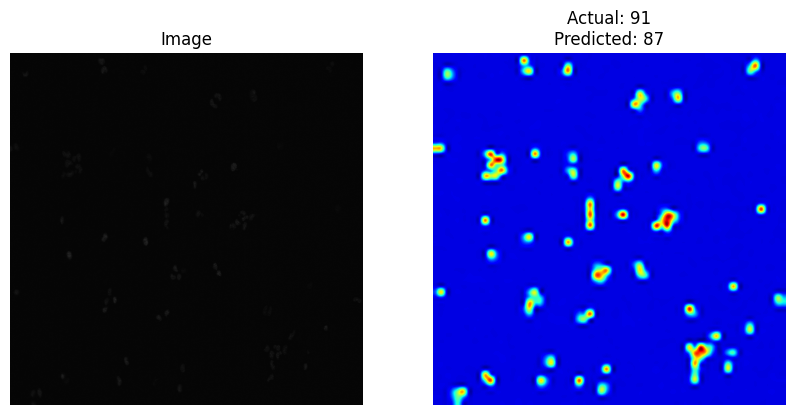

In [64]:
import random
k = random.randint(0, len(dmaps)-1)
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(imgs[k].permute(1, 2, 0))
plt.title("Image")
plt.axis('off')
plt.subplot(1, 2, 2)

resized = cv2.resize(dmaps[k].numpy(), (1024, 1024), interpolation=cv2.INTER_CUBIC) * (16*16)
plt.imshow(resized, cmap='jet')
plt.title(f"Actual: {labels[k].numpy().sum():.0f}\nPredicted: {dmaps[k].sum().item():.0f}")
plt.axis('off')
plt.show()

In [ ]:
for i,img_path in enumerate(test_images_list):
    img = Image.open(img_path).convert('RGB')
    gt = h5py.File(img_path.replace('images', 'densities').replace('.png', '.h5'), 'r')['density'][()]

    
    img = transfroms(img).unsqueeze(0)
    print(img.shape)
    pred = model(img)
    print(pred.shape)
    print(f"GT: {gt.sum()}, Pred: {pred.sum().item()}")

    if i == 10:
        break
    
    

In [4]:
# create trainer
trainer = pl.Trainer(
    accelerator='auto',
    logger=None,
    max_epochs=1)

# test the model
trainer.test(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/abdu/miniconda3/envs/light/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

GT: 293.0, Pred: 302.9873352050781
GT: 176.0, Pred: 163.28053283691406
GT: 107.0, Pred: 213.24798583984375
GT: 174.0, Pred: 167.15341186523438
GT: 325.0, Pred: 327.0400390625
GT: 270.0, Pred: 166.92312622070312
GT: 212.0, Pred: 209.18057250976562
GT: 112.0, Pred: 108.40308380126953
GT: 25.0, Pred: 22.578052520751953
GT: 30.0, Pred: 61.43741989135742
GT: 173.0, Pred: 169.101318359375
GT: 91.0, Pred: 87.41024780273438
GT: 346.0, Pred: 343.4853515625
GT: 146.0, Pred: 140.1890869140625
GT: 521.0, Pred: 500.4698486328125
GT: 197.0, Pred: 172.52760314941406
GT: 175.0, Pred: 167.32345581054688
GT: 209.0, Pred: 218.148193359375
GT: 30.0, Pred: 26.397552490234375
GT: 413.0, Pred: 419.095458984375
GT: 225.0, Pred: 188.7044677734375
GT: 91.0, Pred: 84.88914489746094
GT: 63.0, Pred: 60.7177734375
GT: 86.0, Pred: 83.80023193359375
GT: 306.0, Pred: 305.17987060546875
GT: 595.0, Pred: 477.46746826171875
GT: 358.0, Pred: 290.914794921875
GT: 112.0, Pred: 108.77481079101562
GT: 956.0, Pred: 1058.354614

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     2439.064697265625     │
│         test_mae          │    21.861818313598633     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2439.064697265625, 'test_mae': 21.861818313598633}]

In [21]:
for i in model.test_images_list:
    print(f"{i.split('/')[-1]},")

348.png,
360.png,
3020.png,
2896.png,
2882.png,
943.png,
2712.png,
1541.png,
1958.png,
1756.png,
598.png,
573.png,
1540.png,
942.png,
2707.png,
2897.png,
836.png,
2840.png,
163.png,
177.png,
3021.png,
1144.png,
1622.png,
1187.png,
411.png,
2467.png,
2473.png,
1387.png,
2671.png,
2659.png,
1350.png,
1422.png,
2711.png,
1797.png,
2507.png,
1754.png,
216.png,
1966.png,
969.png,
772.png,
1345.png,
1386.png,
612.png,
2843.png,
1392.png,
389.png,
362.png,
1180.png,
414.png,
1143.png,
2462.png,
602.png,
616.png,
65.png,
71.png,
992.png,
2728.png,
1221.png,
1547.png,
979.png,
2066.png,
574.png,
2502.png,
2271.png,
213.png,
575.png,
1546.png,
70.png,
1432.png,
2477.png,
403.png,
1197.png,
1801.png,
3019.png,
8.png,
72.png,
775.png,
2529.png,
1746.png,
1974.png,
2919.png,
984.png,
1380.png,
2689.png,
1155.png,
1828.png,
459.png,
2361.png,
1668.png,
1654.png,
28.png,
934.png,
1913.png,
276.png,
2599.png,
1906.png,
1912.png,
1523.png,
1537.png,
2189.png,
2412.png,
470.png,
1694.png,
2389.png,
116.